In [1]:
import torch
torch.__version__

'1.9.0+cu102'

In [2]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html


In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [4]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print()
print(data)
print('======================')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(out, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [6]:
def train(model, useGNN=True):
    model.train()
    optimizer.zero_grad() 
    if useGNN:
        out = model(data.x, data.edge_index)
    else:
        out = model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask]) 
    loss.backward() 
    optimizer.step() 
    return loss

def test(model, useGNN=True):
    model.eval()
    if useGNN:
        out = model(data.x, data.edge_index)
    else:
        out = model(data.x)
    pred = out.argmax(dim=1) 
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc, out

In [7]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


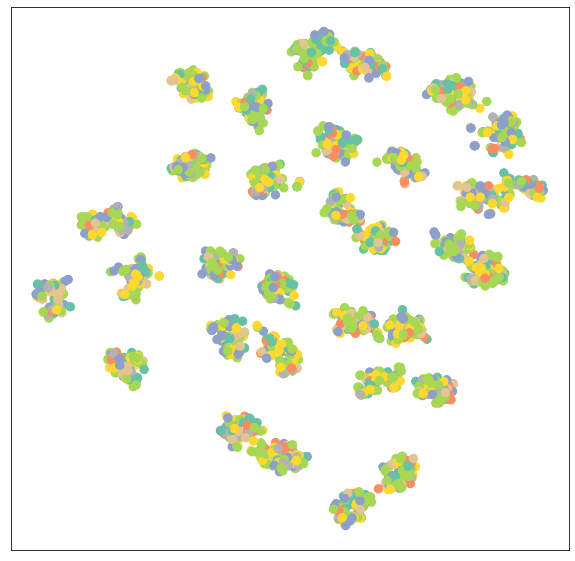

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels):
        super(MLP, self).__init__()
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x
    
model = MLP(dataset.num_features, dataset.num_classes, 16)
print(model)

out = model(data.x)
visualize(out, data.y)

Epoch 20 Loss: 1.7636
Epoch 40 Loss: 1.3485
Epoch 60 Loss: 0.9097
Epoch 80 Loss: 0.7035
Epoch 100 Loss: 0.4885
Epoch 120 Loss: 0.5302
Epoch 140 Loss: 0.5095
Epoch 160 Loss: 0.4993
Epoch 180 Loss: 0.4217
Epoch 200 Loss: 0.4634
Test Accuracy: 0.5900


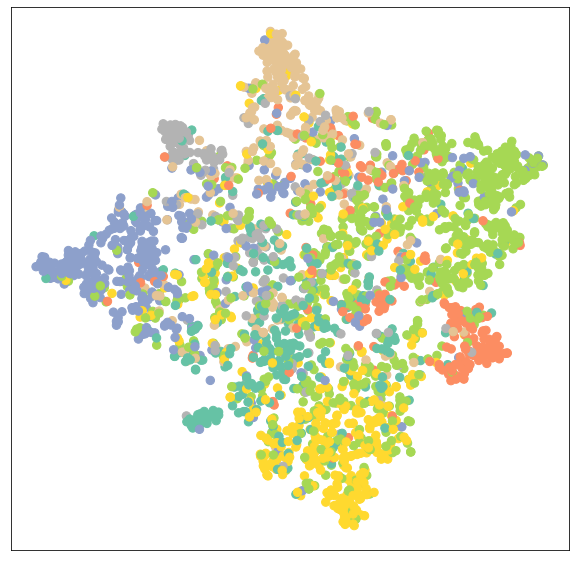

In [9]:
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) 

for epoch in range(200):
    loss = train(model, False)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1} Loss: {loss:.4f}")

test_acc, out = test(model, False)
print(f"Test Accuracy: {test_acc:.4f}")

visualize(out, data.y)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


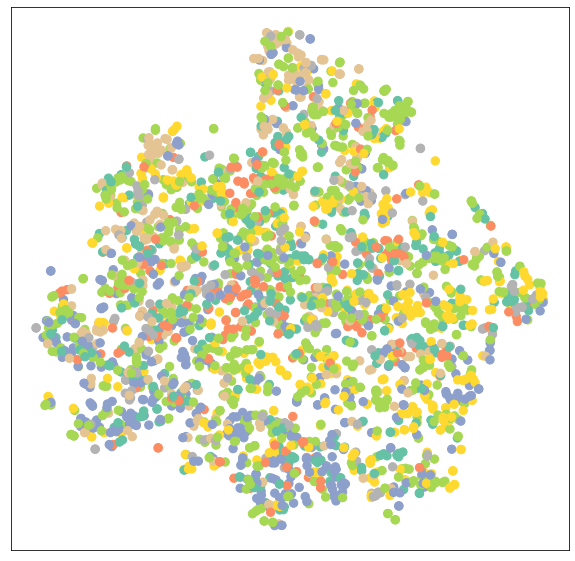

In [10]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(dataset.num_features, dataset.num_classes, hidden_channels=16)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
data.to(device)
print(model)

out = model(data.x, data.edge_index)
visualize(out.cpu(), data.y.cpu())

Epoch 20 Loss: 1.6776
Epoch 40 Loss: 1.2817
Epoch 60 Loss: 0.8992
Epoch 80 Loss: 0.6912
Epoch 100 Loss: 0.5730
Epoch 120 Loss: 0.4938
Epoch 140 Loss: 0.3837
Epoch 160 Loss: 0.3591
Epoch 180 Loss: 0.3473
Epoch 200 Loss: 0.3212
Test Accuracy: 0.8040


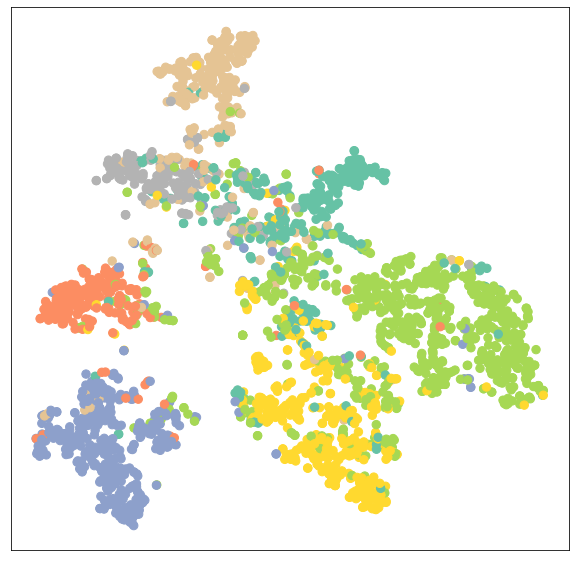

In [11]:
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) 

for epoch in range(200):
    loss = train(model)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1} Loss: {loss:.4f}")

test_acc, out = test(model)
print(f"Test Accuracy: {test_acc:.4f}")

visualize(out.cpu(), data.y.cpu())

GAT(
  (conv1): GATConv(1433, 16, heads=1)
  (conv2): GATConv(16, 7, heads=1)
)


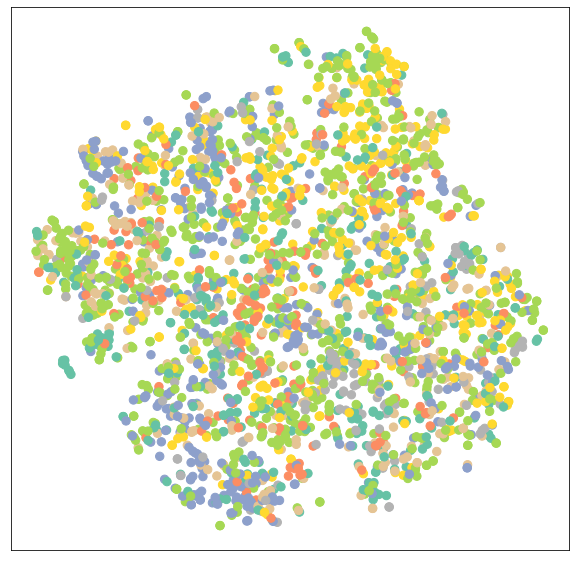

In [12]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(dataset.num_features, dataset.num_classes, hidden_channels=16)
model.to(device)
print(model)

out = model(data.x, data.edge_index)
visualize(out.cpu(), data.y.cpu())

Epoch 20 Loss: 1.7157
Epoch 40 Loss: 1.2488
Epoch 60 Loss: 0.8662
Epoch 80 Loss: 0.5704
Epoch 100 Loss: 0.4328
Epoch 120 Loss: 0.3686
Epoch 140 Loss: 0.2755
Epoch 160 Loss: 0.2731
Epoch 180 Loss: 0.2050
Epoch 200 Loss: 0.2920
Test Accuracy: 0.7780


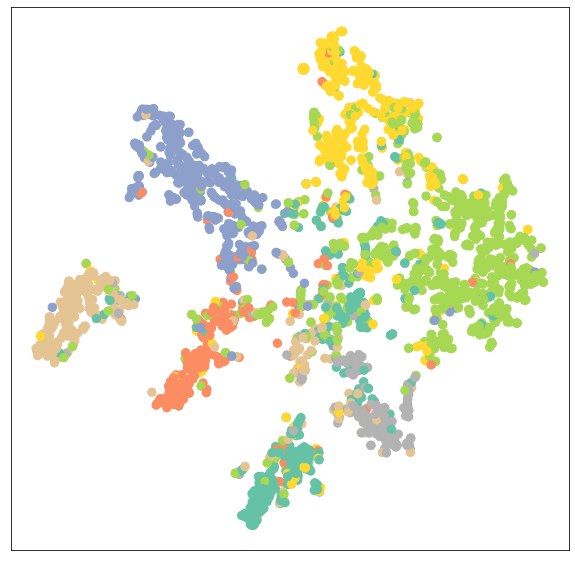

In [13]:
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) 

for epoch in range(200):
    loss = train(model)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1} Loss: {loss:.4f}")

test_acc, out = test(model)
print(f"Test Accuracy: {test_acc:.4f}")

visualize(out.cpu(), data.y.cpu())